In [1]:
import numpy as np
from plot import plot, plot_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from bct.algorithms import(centrality, clustering, degree, distance, modularity, core, similarity, efficiency)
from scipy.stats import pearsonr

In [2]:
dataset = np.load("datasets/oasis_data.npy")
dataset = np.delete(dataset,88,axis=0)
simulated_dataset = np.load("datasets/multivariate_simulation_data_2.npy")

In [3]:
def compute_network_metrics(G):
    ci = np.arange(len(G)) + 1
    G_nx = nx.from_numpy_array(G)
    
    spectral_radius = max(np.abs(np.linalg.eigvals(G)))
    mean_node_strength = statistics.mean(degree.strengths_und(G))
    d_pos, d_neg = centrality.diversity_coef_sign(G, ci)
    mean_d_pos = statistics.mean(d_pos)
    p_pos, p_neg = centrality.participation_coef_sign(G, ci)
    mean_p_pos = statistics.mean(p_pos)
    mean_betweenness_centrality = statistics.mean(centrality.betweenness_wei(G))
    mean_eigenv_centrality = statistics.mean(centrality.eigenvector_centrality_und(G))
    communities = nx.algorithms.community.greedy_modularity_communities(G_nx)
    modularity = nx.algorithms.community.modularity(G_nx, communities)
    density = nx.density(G_nx)
    c = clustering.transitivity_wu(G)
    global_efficiency = efficiency.efficiency_wei(G)
    local_efficiency = efficiency.efficiency_wei(G, local=True)
    avg_l = statistics.mean(local_efficiency)
    
    metrics = {
        'node_strength': mean_node_strength,
        'diversity_pos': mean_d_pos,
        'participation_pos': mean_p_pos,
        'betweenness_centrality': mean_betweenness_centrality,
        'eigenvector_centrality': mean_eigenv_centrality,
        'modularity': modularity,
        'density': density,
        'clustering': c,
        'spectral_radius': spectral_radius,
        'global_efficiency': global_efficiency,
        'local_efficiency': avg_l
    }
    
    return metrics

In [4]:
def get_metrics_dataset(dataset):
    dataset_metrics = []
    for n_subject in range(dataset.shape[0]):
        for n_t in range(dataset.shape[1]):
            graph = dataset[n_subject, n_t, :, :]
            metrics = compute_network_metrics(graph)
            dataset_metrics.append(np.array(list(metrics.values())))
    
    return np.array(dataset_metrics)

In [6]:
print(simulated_dataset.shape)

(200, 3, 35, 35, 1)


In [7]:
simulated_dataset_metrics = get_metrics_dataset(simulated_dataset[:,:,:,:,0])
dataset_metrics = get_metrics_dataset(dataset)


In [9]:
np.save('oasis_metrics.npy', dataset_metrics)
np.save('simulated_metrics.npy',simulated_dataset_metrics)

In [4]:
dataset_metrics = np.load('oasis_metrics.npy')
simulated_dataset_metrics = np.load('simulated_metrics.npy')

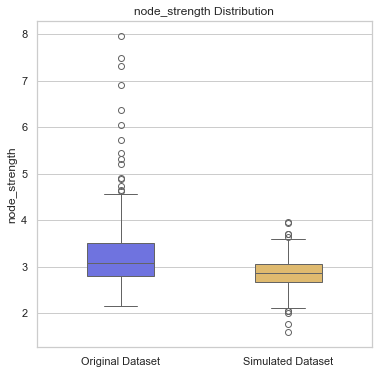

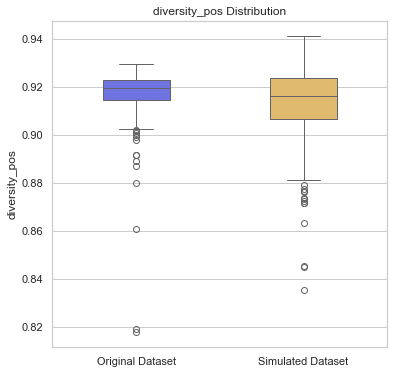

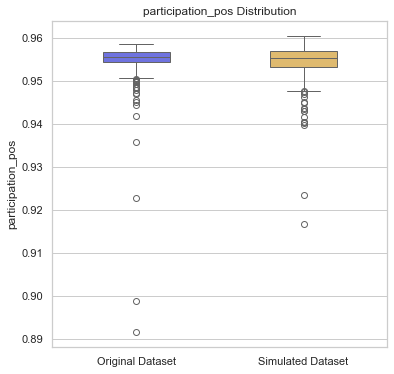

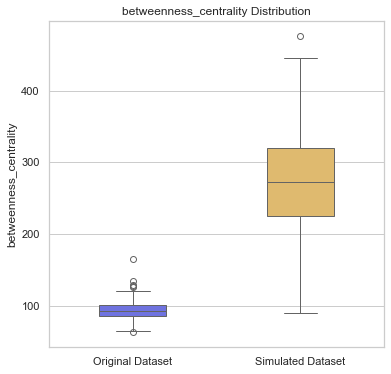

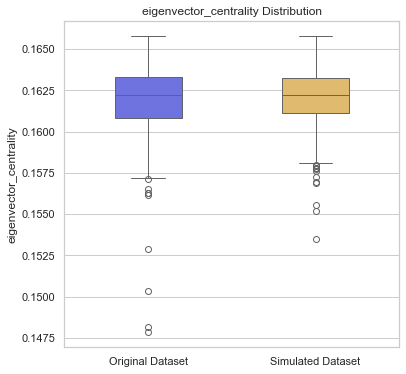

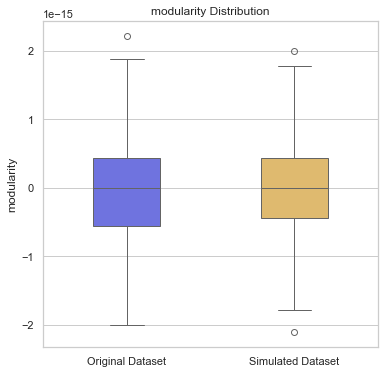

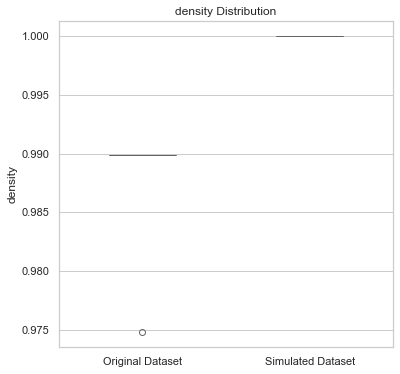

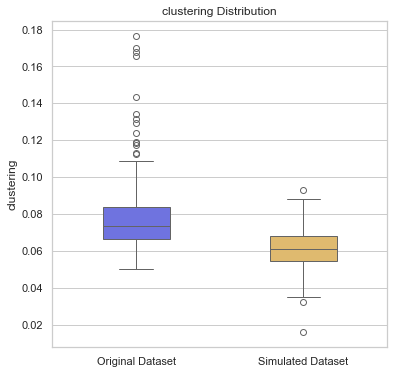

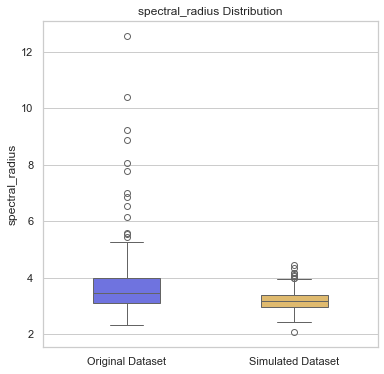

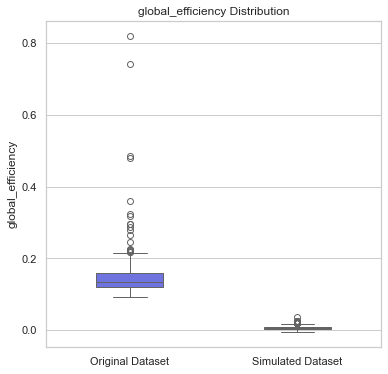

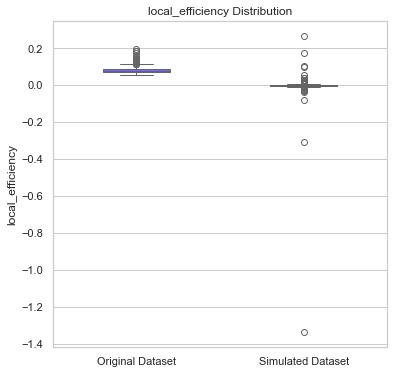

In [23]:

# List of metric names as keys in the order of computation
metric_names = ['node_strength', 'diversity_pos', 'participation_pos', 'betweenness_centrality',
                'eigenvector_centrality', 'modularity', 'density', 'clustering', 'spectral_radius', 'global_efficiency', 'local_efficiency']

# Number of metrics
num_metrics = len(metric_names)

# Create a DataFrame to make plotting easier
data = []
for i, metric_name in enumerate(metric_names):
    data.append(pd.DataFrame({
        'Metric': metric_name,
        'Value': dataset_metrics[:, i],
        'Dataset': 'Original Dataset'
    }))
    data.append(pd.DataFrame({
        'Metric': metric_name,
        'Value': simulated_dataset_metrics[:, i],
        'Dataset': 'Simulated Dataset'
    }))
    
df = pd.concat(data)

# Plot each metric
for metric_name in metric_names:
    plt.figure(figsize=(6, 6))
    sns.set(style="whitegrid")
    ax = sns.boxplot(x='Dataset', y='Value', data=df[df['Metric'] == metric_name], palette={'Original Dataset': '#5c61f2', 'Simulated Dataset': '#f2c05c'}, hue='Dataset', legend=False, width=0.4)
    plt.title(f'{metric_name} Distribution')
    plt.ylabel(metric_name)
    plt.xlabel('')
    plt.show()